In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir('/content/drive/MyDrive/Colab Notebooks/DDMD-Image-Captioning/')
!ls

Mounted at /content/drive
all_images		     Flickr8k.lemma.token.txt
CrowdFlowerAnnotations.txt   Flickr_8k.testImages.txt
DDMD-Image-Captioning.ipynb  Flickr8k.token.txt
ddmd.token.txt		     Flickr_8k.trainImages.txt
ExpertAnnotations.txt	     __MACOSX
Flicker8k_Dataset	     readme.txt
Flickr_8k.devImages.txt


In [ ]:
%matplotlib inline

# Setup and Configuration

In [ ]:
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
# !unzip -qq Flickr8k_Dataset.zip
# !unzip -qq Flickr8k_text.zip
# !rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
class DataConfiguration():
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Path to the images
    IMAGES_PATH = "all_images"

    # Desired image dimensions
    IMAGE_SIZE = (299, 299)

    # Vocabulary size
    VOCAB_SIZE = 10000

    # Fixed length allowed for any sequence
    SEQ_LENGTH = 25

    # Dimension for the image embeddings and token embeddings
    EMBED_DIM = 512

    # Per-layer units in the feed-forward network
    FF_DIM = 512

    # Other training parameters
    BATCH_SIZE = 10
    EPOCHS = 5
    AUTOTUNE = tf.data.AUTOTUNE

DataConfig = DataConfiguration()





# Preparing dataset

In [ ]:
with open("ddmd.token.txt") as filee:
  caption = filee.readlines()
  print(len(caption))

69408


In [ ]:
class Dataset:
  def __init__(self) -> None:
    super().__init__()
   
  def loadCaptionData(self, filename):
    """
    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    with open(filename) as captionFile:
      captionData = captionFile.readlines()
      captionMapping = {}
      textData = []
      imagesToSkip = set()

      print(captionData[2].rstrip('\n').split('\t')[0])

      for index, line in enumerate(captionData):
        if (index == len(captionData) - 1):
          break
        else:
          line = line.rstrip("\n")
        # Image name and captions are separated using a tab
        try:
          imgName, caption = line.split('\t')
        except ValueError:
          continue
        
        # Each image is repeated five times for the five different captions.
        # Each image name has a siffic `#caption number`

        # imgName = imgName.split('#')[0]
        imgName = os.path.join(DataConfig.IMAGES_PATH, imgName.strip())

        tokens = caption.strip().split()

        if len(tokens) < 1:
          imagesToSkip.add(imgName)
          continue

        if imgName.endswith("jpeg"):
          caption = "<start> " + caption.strip() + " <end>"
          textData.append(caption)
          

          if imgName in captionMapping:
            captionMapping[imgName].append(caption)
          else:
            captionMapping[imgName] = [caption]

      print(len(imagesToSkip), "len")

      # for i, imgName in enumerate(imagesToSkip):
      #   if imgName in captionMapping:
      #     del captionMapping[imgName]

      # if i == 1:
      print("sadfasdf", len(captionMapping))
      return captionMapping, textData

    
  def trainValidationSplit(self, captionData, trainSize = 0.8, shuffle=True):
    # Get the list of all images
    allImages = list(captionData.keys())

    # Shuffle if necessary
    if shuffle:
      np.random.shuffle(allImages)

    # Split into training and validation sets
    trainSize = int(len(captionData) * trainSize)
    trainingData = {imgName: captionData[imgName] for imgName in allImages[:trainSize]}
    validationData = {imgName: captionData[imgName] for imgName in allImages[trainSize:]}

    return trainingData, validationData
  
  def decodeAndResize(self, imgPath):
    img = tf.io.read_file(imgPath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, DataConfig.IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

  def processInput(self, imgPath, captions):
    return self.decodeAndResize(imgPath), vectorization(captions)

  def makeDataset(self, images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(DataConfig.BATCH_SIZE * 8)
    dataset = dataset.map(self.processInput, num_parallel_calls = DataConfig.AUTOTUNE)
    dataset = dataset.batch(DataConfig.BATCH_SIZE).prefetch(DataConfig.AUTOTUNE)
    
    return dataset


dataset = Dataset()

captionsMapping, textData = dataset.loadCaptionData("ddmd.token.txt")

trainData, validData = dataset.trainValidationSplit(captionsMapping)
print("No. of training sample: ", len(trainData))
print("No. of valid sample: ", len(validData))
  

10_1.jpeg
0 len
sadfasdf 281
No. of training sample:  224
No. of valid sample:  57


# Vectorizeing the text data

In [ ]:
class Vectorizer(TextVectorization):
  def __init__(self)->None:
    super().__init__()
    self.strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    self.strip_chars = strip_chars.replace("<", "")
    self.strip_chars = strip_chars.replace(">", "")
  
 

  def customStandardization(self, inputString):
    lowercase = tf.string.lower(inputString)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(self.strip_chars), "")
  

  

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=DataConfig.VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=DataConfig.SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(textData)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [ ]:
trainDataset = dataset.makeDataset(list(trainData.keys()), list(trainData.values()))
validDataset = dataset.makeDataset(list(validData.keys()), list(validData.values()))

In [ ]:
print(validDataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 25), dtype=tf.int64, name=None))>


# Building the model

In [ ]:
class CNNModel(keras.models.Model):
  def __init__(self):
    super().__init__()

  def getCnnModel(self):
    baseModel = efficientnet.EfficientNetB0(input_shape = (* DataConfig.IMAGE_SIZE, 3), include_top=False, weights="imagenet",)
    # Freeze feature extractor
    baseModel.trainable = False
    baseModelOut = baseModel.output
    baseModelOut = layers.Reshape((-1, baseModelOut.shape[-1]))(baseModelOut)
    cnnModel = keras.models.Model(baseModel.input, baseModelOut)
    return cnnModel

In [ ]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embedDim, denseDim, numHeads, **kwargs):
    super().__init__(**kwargs)
    self.embedDim = embedDim
    self.denseDim = denseDim
    self.numHeads = numHeads
    self.attention1 = layers.MultiHeadAttention(num_heads = numHeads, key_dim = embedDim, dropout = 0.0 )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dense1 = layers.Dense(embedDim, activation="relu")

  def call(self, inputs, training, mask=None):
    inputs = self.layernorm1(inputs)
    inputs = self.dense1(inputs)

    attentionOutput1 = self.attention1(query=inputs, value = inputs, key=inputs, attention_mask = None, training = training)
    out1 = self.layernorm2(inputs + attentionOutput1)
    return out1


In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequenceLength, vocabSize, embedDim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocabSize, output_dim=embedDim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequenceLength, output_dim=embedDim
        )
        self.sequenceLength = sequenceLength
        self.vocab_size = vocabSize
        self.embed_dim = embedDim
        self.embed_scale = tf.math.sqrt(tf.cast(embedDim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embedDim, ffDim, numHeads, **kwargs):
        super().__init__(**kwargs)
        self.embedDim = embedDim
        self.ffDim = ffDim
        self.numHeads = numHeads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=numHeads, key_dim=embedDim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=numHeads, key_dim=embedDim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ffDim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embedDim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embedDim=DataConfig.EMBED_DIM, sequenceLength=DataConfig.SEQ_LENGTH, vocabSize=DataConfig.VOCAB_SIZE
        )
        self.out = layers.Dense(DataConfig.VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnnModel, encoder, decoder, numCaptionsPerImage=5, imageAug=None,
    ):
        super().__init__()
        self.cnnModel = cnnModel
        self.encoder = encoder
        self.decoder = decoder
        self.lossTracker = keras.metrics.Mean(name="loss")
        self.accTracker = keras.metrics.Mean(name="accuracy")
        self.numCaptionsPerImage = numCaptionsPerImage
        self.imageAug = imageAug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.imageAug:
            batch_img = self.imageAug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnnModel(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.numCaptionsPerImage):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.numCaptionsPerImage)
        self.lossTracker.update_state(batch_loss)
        self.accTracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.lossTracker.result(), "acc": self.accTracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnnModel(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.numCaptionsPerImage):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.numCaptionsPerImage)

        # 4. Update the trackers
        self.lossTracker.update_state(batch_loss)
        self.accTracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.lossTracker.result(), "acc": self.accTracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.lossTracker, self.accTracker]

In [ ]:
model = CNNModel()

cnnModel = model.getCnnModel()
encoder = TransformerEncoder(embedDim=DataConfig.EMBED_DIM, denseDim=DataConfig.FF_DIM, numHeads = 1)
decoder = TransformerDecoder(embedDim=DataConfig.EMBED_DIM, ffDim=DataConfig.FF_DIM, numHeads = 2)
captionModel = ImageCaptioningModel(
    cnnModel=cnnModel, encoder=encoder, decoder=decoder, imageAug=image_augmentation,
)




16705208/16705208 [==============================] - 0s 0us/step


# Model Training

In [ ]:
# Define the loss function
crossEntropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
earlyStopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, postWarmupLearningRate, warmupSteps):
        super().__init__()
        self.postWarmupLearningRate = postWarmupLearningRate
        self.warmupSteps = warmupSteps

    def __call__(self, step):
        globalStep = tf.cast(step, tf.float32)
        warmupSteps = tf.cast(self.warmupSteps, tf.float32)
        warmupProgress = globalStep / warmupSteps
        warmupLearningRate = self.postWarmupLearningRate * warmupProgress
        return tf.cond(
            globalStep < warmupSteps,
            lambda: warmupLearningRate,
            lambda: self.postWarmupLearningRate,
        )


# Create a learning rate schedule
numTrainSteps = len(trainDataset) * DataConfig.EPOCHS
numWarmupSteps = numTrainSteps // 15
lrSchedule = LRSchedule(postWarmupLearningRate=1e-4, warmupSteps=numWarmupSteps)

# Compile the model
captionModel.compile(optimizer="adam", loss=crossEntropy)

# Fit the model
history = captionModel.fit(
    trainDataset,
    epochs=DataConfig.EPOCHS,
    validation_data=validDataset,
    # callbacks=[earlyStopping],
)

Epoch 1/5
23/23 [==============================] - 57s 2s/step - loss: 5.0787 - acc: 0.6310 - val_loss: 0.7654 - val_acc: 0.9333
Epoch 2/5
23/23 [==============================] - 4s 155ms/step - loss: 0.7372 - acc: 0.9310 - val_loss: 0.4070 - val_acc: 0.9583
Epoch 3/5
23/23 [==============================] - 4s 152ms/step - loss: 0.5854 - acc: 0.9490 - val_loss: 0.4712 - val_acc: 0.9500
Epoch 4/5
23/23 [==============================] - 4s 152ms/step - loss: 0.7106 - acc: 0.9445 - val_loss: 1.1270 - val_acc: 0.9333
Epoch 5/5
23/23 [==============================] - 4s 154ms/step - loss: 2.6891 - acc: 0.8315 - val_loss: 1.2249 - val_acc: 0.8942


# Check ssample prediction

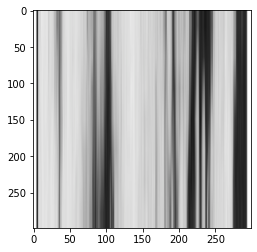

Predicted caption:  figure 5 b cereus 4b at the fourth stage of the growth 45hoursafterinoculation a confocal microscopy image with crystal violet staining in the sample


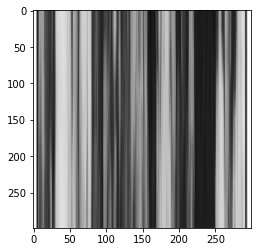

Predicted caption:  figure 5 b cereus 4b at the fourth stage of the growth 45hoursafterinoculation a confocal microscopy image with crystal violet staining in the sample


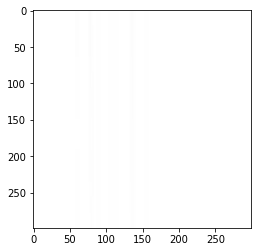

Predicted caption:  figure 5 b cereus 4b at the fourth stage of the growth 45hoursafterinoculation a confocal microscopy image with crystal violet staining in the sample


In [ ]:
vocab = vectorization.get_vocabulary()
indexLookup = dict(zip(range(len(vocab)), vocab))
maxDecodedSentenceLength = DataConfig.SEQ_LENGTH - 1
validImages = list(validData.keys())

def generate_caption():
  # Select random image from the validation dataset
  sampleImg = np.random.choice(validImages)

  sampleImg =  dataset.decodeAndResize(sampleImg)
  img = sampleImg.numpy().clip(0, 255).astype(np.uint8)
  plt.imshow(img)
  plt.show()

  # Pass the image to the CNN
  img = tf.expand_dims(sampleImg, 0)
  img = captionModel.cnnModel(img)

  # Pass the image features to the Transformer encoder
  encodedImg = captionModel.encoder(img, training = False)

  # Generate the caption using transformer decoder
  decodedCaption = "<start> "
  for i in range(maxDecodedSentenceLength):
    tokenizedCaption = vectorization([decodedCaption])[:, :-1]
    mask = tf.math.not_equal(tokenizedCaption, 0)
    predictions = captionModel.decoder(tokenizedCaption, encodedImg, training = False, mask = mask)
    sampledTokenIndex = np.argmax(predictions[0, i, :])
    sampledToken = indexLookup[sampledTokenIndex]
    if sampledToken == " <end>":
      break
    decodedCaption += " " + sampledToken

  decodedCaption = decodedCaption.replace("<start> ", "")
  decodedCaption = decodedCaption.replace(" <end>", "").strip()
  print("Predicted caption: ", decodedCaption)


generate_caption()
generate_caption()
generate_caption()

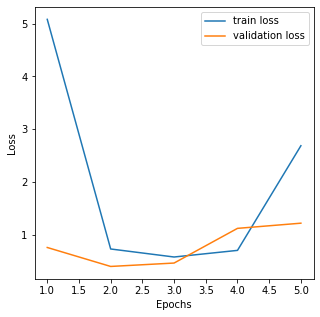

In [ ]:
epochs = range(1, len(history.history['loss'])+1)
fig = plt.figure(figsize = (5,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, history.history['loss'], label='train loss')
plt.plot(epochs, history.history['val_loss'], label= 'validation loss')
plt.legend()
plt.show()